In [1]:
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import numpy as np

# Searching for best model
Comparison of different models:

In [2]:
def make_df(model_names, col1, nr_epochs=None):
    results = pd.DataFrame(columns=[col1, 'Phase', 'Accuracy', 'Epoch'])
    long = {'to': 'Identity'}
    for name in model_names:
        [train_res, val_res] = joblib.load(f"{name}.joblib")
        name_split = name.split('_')
        col1_dict = {'Recognizing': long[name_split[2]], 'Batch size': name_split[6], 'Model': name_split[1]}
        if nr_epochs: rnge = nr_epochs
        else: rnge=len(train_res)
        for i in range(rnge):
            results = results.append({col1: col1_dict[col1], 'Phase': 'train', 'Accuracy': train_res[i],
                                      'Epoch': i}, ignore_index=True)
            results = results.append({col1: col1_dict[col1], 'Phase': 'val', 'Accuracy': val_res[i],
                                      'Epoch': i}, ignore_index=True)
    return results

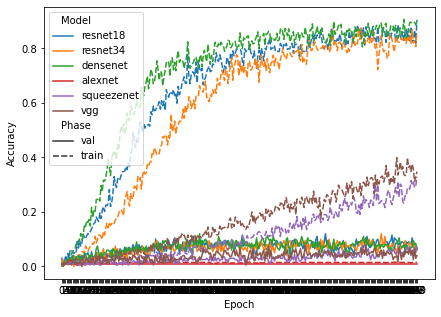

In [3]:
names_id = ['hist_resnet18_to_e_300_b_32', 'hist_resnet34_to_e_300_b_32', 'hist_densenet_to_e_300_b_32',
            'hist_alexnet_to_e_300_b_32',
            'hist_squeezenet_to_e_300_b_32',
            'hist_vgg_to_e_300_b_32']
results = make_df(names_id, 'Model')
plt.figure(figsize=(7,5))
sns.lineplot(data=results, x='Epoch', y='Accuracy', hue='Model', style='Phase', style_order=['val', 'train'])
plt.xticks(list(results['Epoch'].unique()))
plt.savefig('models.png')
plt.show()

### Identity problem
Accuracy of *resnet18* on identity problem:

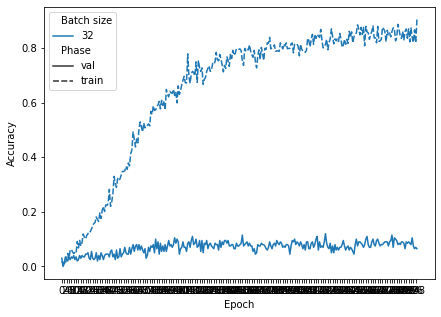

In [4]:
model_names = ['hist_resnet18_to_e_300_b_32']
results = make_df(model_names, 'Batch size')
plt.figure(figsize=(7,5))
sns.lineplot(data=results, x='Epoch', y='Accuracy', hue='Batch size', style='Phase', style_order=['val', 'train'])
plt.xticks(list(results['Epoch'].unique())[::2])
plt.show()

## ResNet34

### Identity problem

Accuracy of *resnet34* on identity problem:
--> best 32, resnet18 learns better

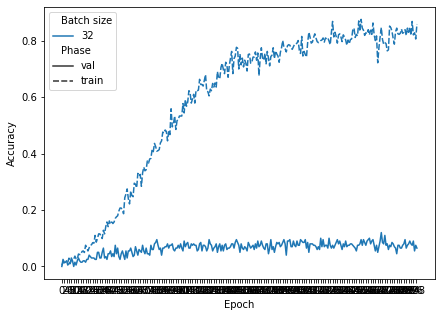

In [5]:
model_names = ['hist_resnet34_to_e_300_b_32']
results = make_df(model_names, 'Batch size')
plt.figure(figsize=(7,5))
sns.lineplot(data=results, x='Epoch', y='Accuracy', hue='Batch size', style='Phase', style_order=['val', 'train'])
plt.xticks(list(results['Epoch'].unique())[::2])
plt.show()

Comparison of resnet18 and resnet34 with learning rate 0.0001 on identity problem.
--> resnet18 learns better

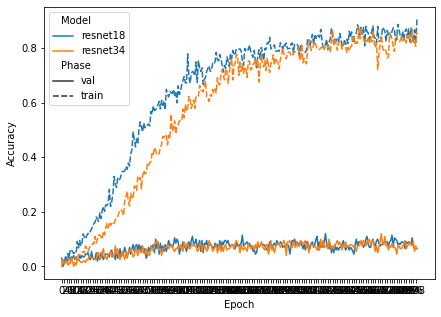

In [6]:
model_names = ['hist_resnet18_to_e_300_b_32', 'hist_resnet34_to_e_300_b_32']
results = make_df(model_names, 'Model')
plt.figure(figsize=(7,5))
sns.lineplot(data=results, x='Epoch', y='Accuracy', hue='Model', style='Phase', style_order=['val', 'train'])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(list(results['Epoch'].unique())[::2])
plt.show()


#
## Conclusion

Training of the best models (densent)

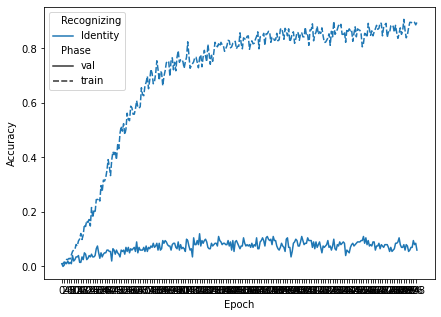

In [7]:
model_names = ['hist_densenet_to_e_300_b_32']
results = make_df(model_names, 'Recognizing')
plt.figure(figsize=(7,5))
sns.lineplot(data=results, x='Epoch', y='Accuracy', hue='Recognizing', style='Phase', style_order=['val', 'train'])
plt.xticks(list(results['Epoch'].unique()[::2]))
plt.savefig('final.png')


In [8]:
#######################################################################################################################

# Results
### Identity

In [9]:

data_dir = "./data_torch"
num_classes = 100
batch_size = 32
num_epochs = 300

In [10]:
import torch
import torch.nn as nn

import os

def initialize_model(model_name, num_classes, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [11]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms

try:
    input_size
except NameError:
    input_size = 224

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create testing dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
# Create testing dataloader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, num_workers=4) for x in ['test']}

dataiter = iter(dataloaders_dict['test'])
images, labels = dataiter.next()

model_names = ['resnet18_to_e_300_b_32', 'resnet34_to_e_300_b_32', 'densenet_to_e_300_b_32',
            'alexnet_to_e_300_b_32',
            'squeezenet_to_e_300_b_32',
            'vgg_to_e_300_b_32']

for model_name in model_names:
    print("Processing: " + model_name)
    model_name_raw = model_name.split("_")[0]
    print("Initializing model: ", model_name_raw)
    model_ft, input_size = initialize_model(model_name_raw, num_classes, use_pretrained=True)
    model_data = torch.load(f"{model_name}.pth")
    model_ft.load_state_dict(model_data)
    model_ft.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloaders_dict['test']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model_ft(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the "{model_name}" network on test images: {100 * correct // total} %')

Initializing Datasets and Dataloaders...
Processing: resnet18_to_e_300_b_32
Initializing model:  resnet18
Accuracy of the "resnet18_to_e_300_b_32" network on test images: 0 %
Processing: resnet34_to_e_300_b_32
Initializing model:  resnet34
Accuracy of the "resnet34_to_e_300_b_32" network on test images: 2 %
Processing: densenet_to_e_300_b_32
Initializing model:  densenet
Accuracy of the "densenet_to_e_300_b_32" network on test images: 0 %
Processing: alexnet_to_e_300_b_32
Initializing model:  alexnet
Accuracy of the "alexnet_to_e_300_b_32" network on test images: 0 %
Processing: squeezenet_to_e_300_b_32
Initializing model:  squeezenet
Accuracy of the "squeezenet_to_e_300_b_32" network on test images: 1 %
Processing: vgg_to_e_300_b_32
Initializing model:  vgg
Accuracy of the "vgg_to_e_300_b_32" network on test images: 1 %
